In [2]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio


from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [3]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
# Dictionary with paths for each emotion
emotion_paths = {
    'Angry': "D:/dataset/audio_emotions/Emotions/Angry",
    'Disgusted': "D:/dataset/audio_emotions/Emotions/Disgusted",
    'Fearful': "D:/dataset/audio_emotions/Emotions/Fearful",
    'Happy': "D:/dataset/audio_emotions/Emotions/Happy",
    'Neutral': "D:/dataset/audio_emotions/Emotions/Neutral",
    'Sad': "D:/dataset/audio_emotions/Emotions/Sad",
    'Surprised': "D:/dataset/audio_emotions/Emotions/Suprised"
}

In [5]:
data = []

# Iterate over each emotion and its corresponding path
for emotion, path in emotion_paths.items():
    # List all .wav files in the directory
    files = [f for f in os.listdir(path) if f.endswith('.wav')]
    
    # For each file, append a tuple of (file_name, emotion) to our data list
    for file in files:
        data.append((file, emotion))

# Convert the data list to a DataFrame
df = pd.DataFrame(data, columns=['file_name', 'label'])

# Display the DataFrame
display(df)

,file_name,label
0,03-01-05-01-01-01-01.wav,Angry
1,03-01-05-01-01-01-02.wav,Angry
2,03-01-05-01-01-01-03.wav,Angry
3,03-01-05-01-01-01-04.wav,Angry
4,03-01-05-01-01-01-05.wav,Angry
...,...,...
12793,YAF_witch_ps.wav,Surprised
12794,YAF_yearn_ps.wav,Surprised
12795,YAF_yes_ps.wav,Surprised
12796,YAF_young_ps.wav,Surprised


In [6]:
df = df.sample(frac=1).reset_index(drop=True)
df

,file_name,label
0,03-01-04-02-01-02-24.wav,Sad
1,03-02-06-01-02-02-06.wav,Fearful
2,OAF_size_neutral.wav,Neutral
3,03-02-01-01-01-01-23.wav,Neutral
4,1083_IWW_SAD_XX.wav,Sad
...,...,...
12793,103-02-01-01-01-01-01.wav,Neutral
12794,OAF_hush_sad.wav,Sad
12795,1018_TSI_HAP_XX.wav,Happy
12796,YAF_whip_angry.wav,Angry


label
<class 'str'>    12798
Name: count, dtype: int64


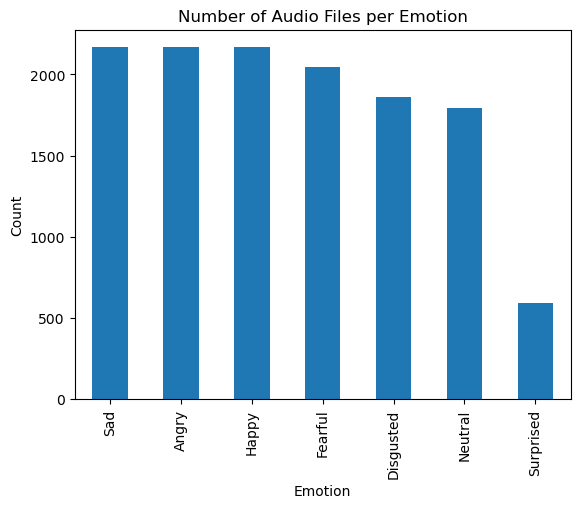

label
Sad          2167
Angry        2167
Happy        2167
Fearful      2047
Disgusted    1863
Neutral      1795
Surprised     592
Name: count, dtype: int64


In [7]:
print(df['label'].apply(type).value_counts())
df['label'] = df['label'].astype(str)
df['label'] = df['label'].astype(str)
value_counts = df['label'].value_counts()
value_counts.plot(kind='bar')
plt.title('Number of Audio Files per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()



counts = df['label'].value_counts()
print(counts)


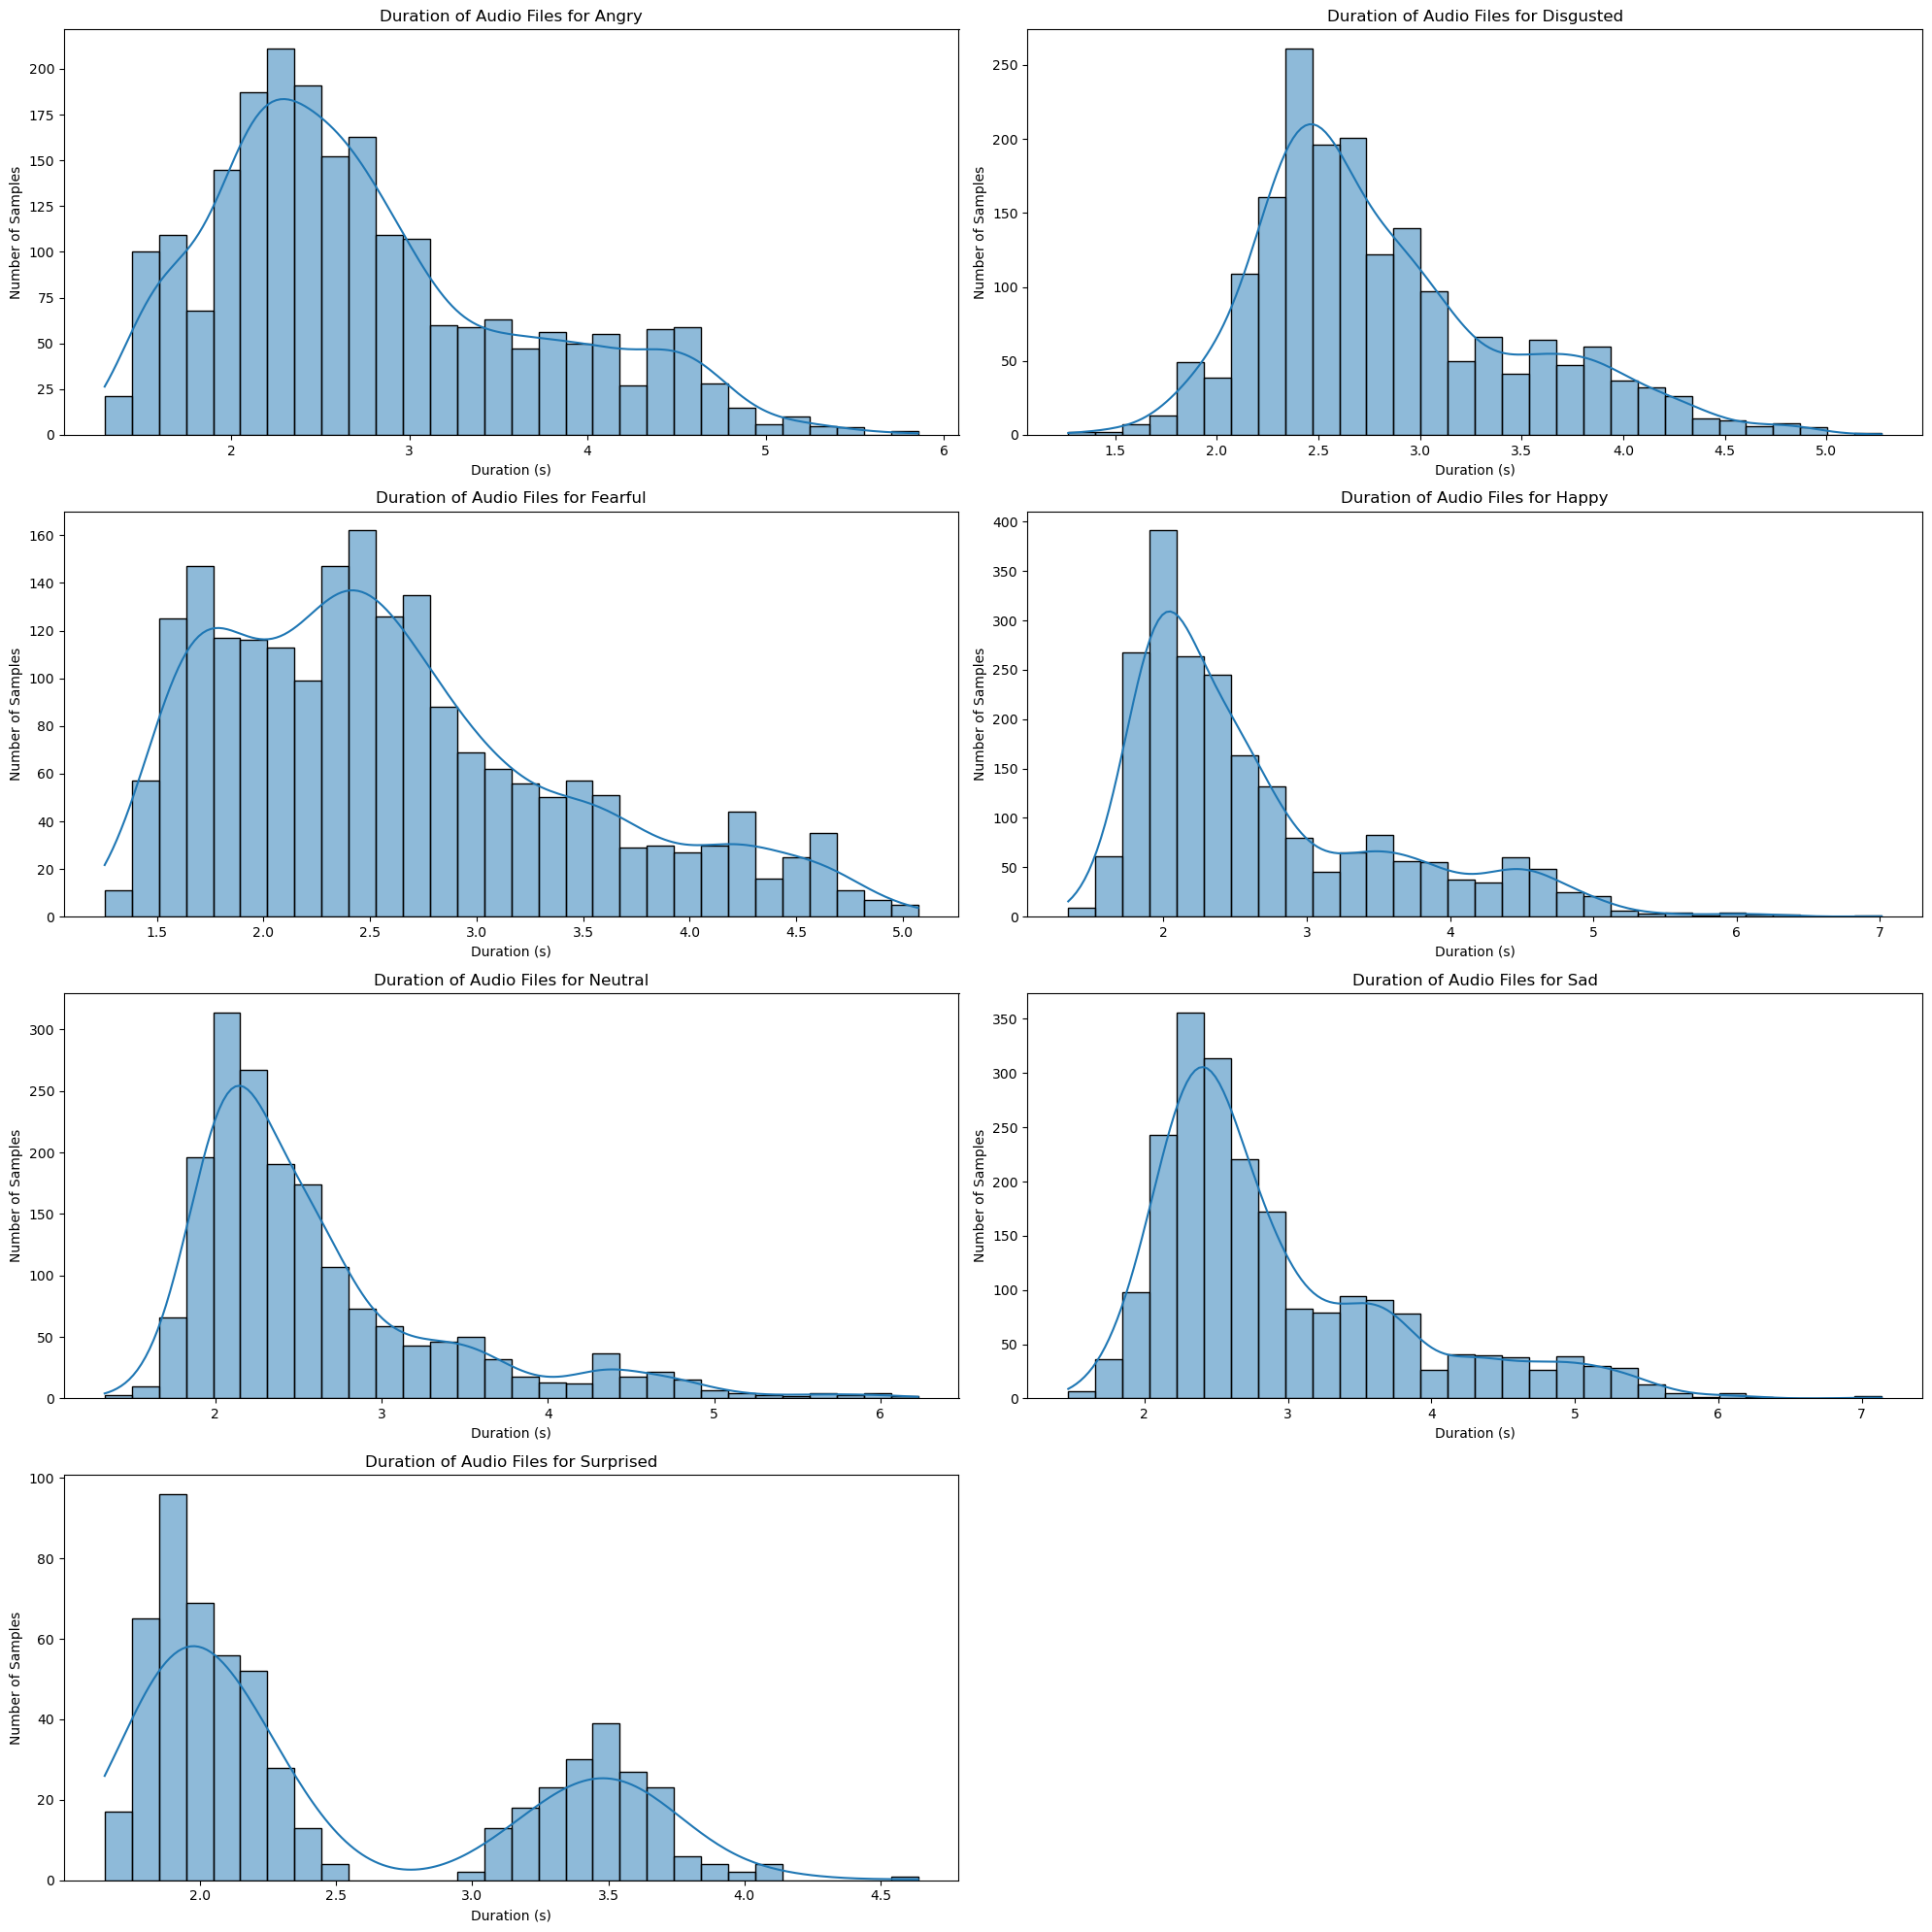

In [8]:
# Create a new column in the dataframe for durations
df['duration'] = [librosa.get_duration(filename=os.path.join(emotion_paths[row['label']], row['file_name'])) 
                  for _, row in df.iterrows()]

plt.figure(figsize=(20, 20))

for i, emotion in enumerate(emotion_paths.keys(), 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[df['label'] == emotion]['duration'], bins=30, kde=True)
    plt.title(f'Duration of Audio Files for {emotion}')
    plt.xlabel('Duration (s)')
    plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()



In [9]:
df

,file_name,label,duration
0,03-01-04-02-01-02-24.wav,Sad,4.571250
1,03-02-06-01-02-02-06.wav,Fearful,4.504500
2,OAF_size_neutral.wav,Neutral,2.238675
3,03-02-01-01-01-01-23.wav,Neutral,4.404396
4,1083_IWW_SAD_XX.wav,Sad,2.736063
...,...,...,...
12793,103-02-01-01-01-01-01.wav,Neutral,4.237583
12794,OAF_hush_sad.wav,Sad,2.736012
12795,1018_TSI_HAP_XX.wav,Happy,1.501500
12796,YAF_whip_angry.wav,Angry,2.005489


In [10]:
from IPython.display import Audio, display

for emotion in emotion_paths.keys():
    sample_file = df[df['label'] == emotion].sample(1).iloc[0]
    file_path = os.path.join(emotion_paths[sample_file['label']], sample_file['file_name'])
    
    print(f"Playing {emotion}:")
    display(Audio(filename=file_path))


Playing Angry:


Playing Disgusted:


Playing Fearful:


Playing Happy:


Playing Neutral:


Playing Sad:


Playing Surprised:


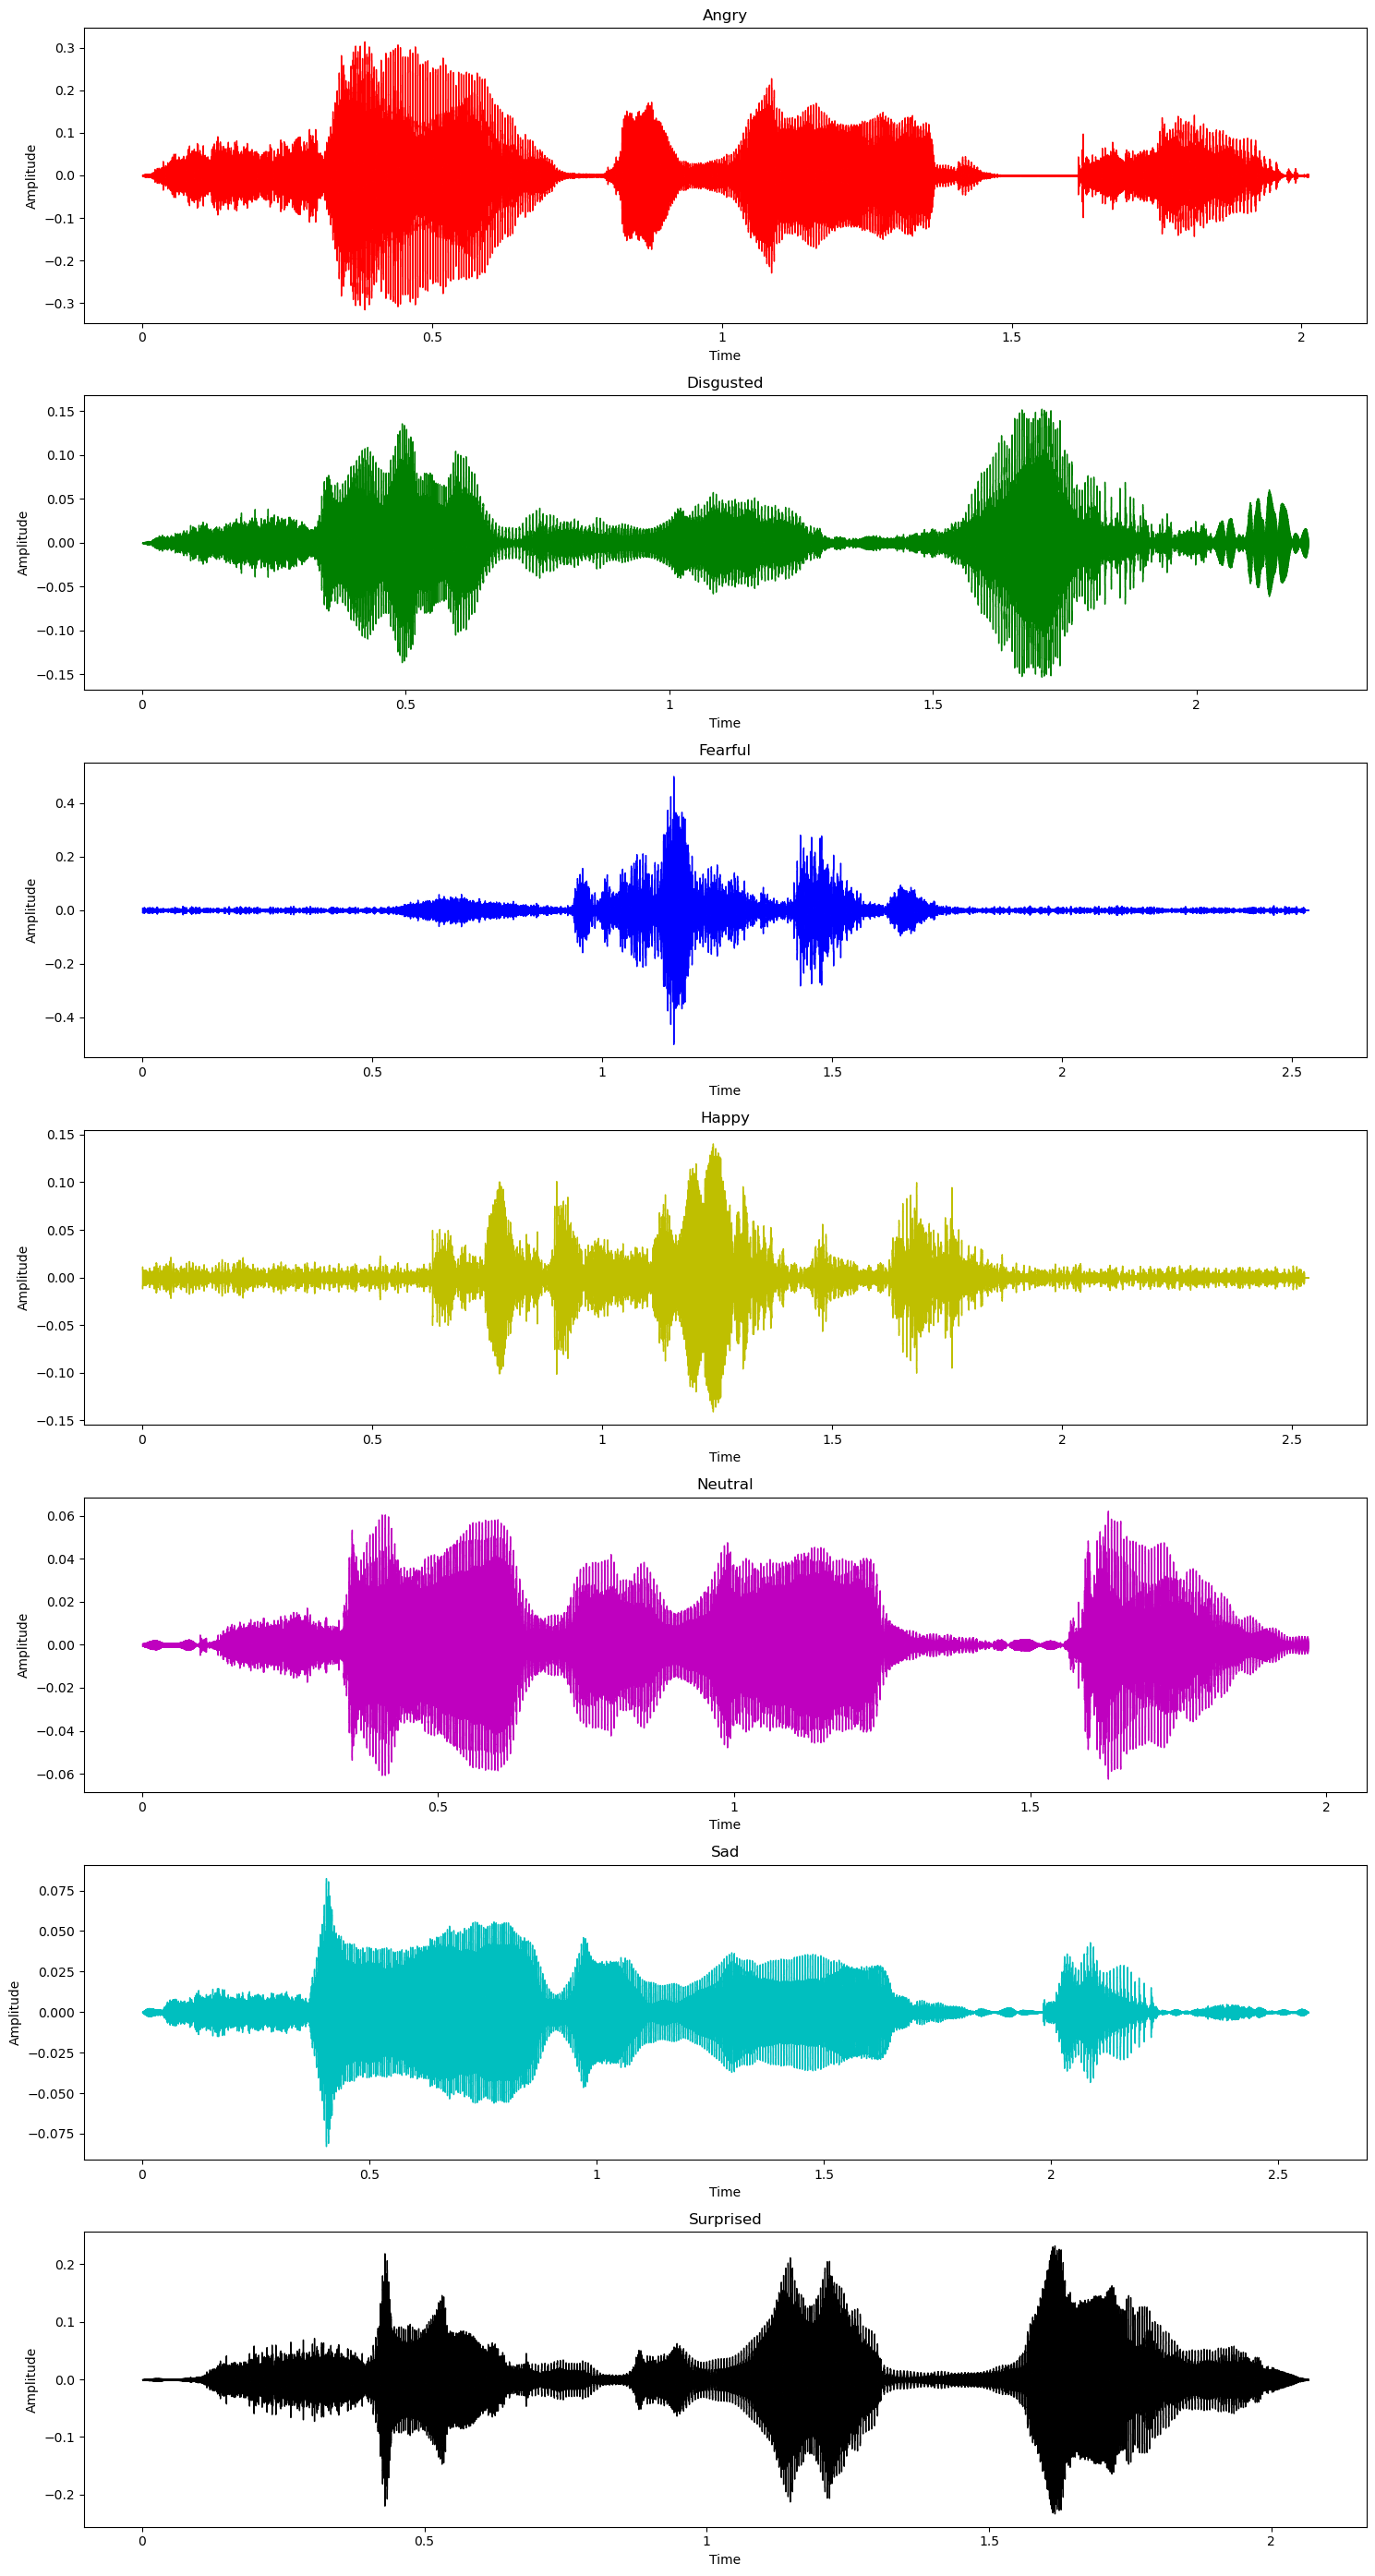

In [11]:
def display_audio_waveforms(df, emotion_paths):
    # Set up the figure and subplots
    num_emotions = len(emotion_paths)
    fig, axs = plt.subplots(num_emotions, 1, figsize=(15, 4 * num_emotions))
    
    # If there's only one emotion, axs won't be an array. Fix that.
    if num_emotions == 1:
        axs = [axs]

    colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'orange']  # Add more colors if needed
    
    for ax, (emotion, path) in zip(axs, emotion_paths.items()):
        # Randomly select an audio file for the current emotion
        sample_file = df[df['label'] == emotion].sample(1).iloc[0]
        file_path = os.path.join(path, sample_file['file_name'])
        
        # Load the audio file using librosa
        y, sr = librosa.load(file_path, duration=5)
        
        # Display the waveform
        ax.set_title(emotion)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        librosa.display.waveshow(y, sr=sr, ax=ax, color=colors.pop(0))  # Use color.pop(0) to cycle through colors
    
    plt.tight_layout()
    plt.show()

# Assume df and emotion_paths are defined
display_audio_waveforms(df, emotion_paths)



In [12]:
def extract_features(audio_path, max_pad_len=300):
    y, sr = librosa.load(audio_path, duration=5)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # If the audio file is shorter than our maximum pad length
    if (max_pad_len > mfccs.shape[1]):
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else, if it's longer, truncate it
    else:
        mfccs = mfccs[:, :max_pad_len]
    
    return mfccs


In [13]:
def get_full_path(row):
    return os.path.join(emotion_paths[row['label']], row['file_name'])

df['full_path'] = df.apply(get_full_path, axis=1)


In [14]:
X = np.array([extract_features(f) for f in df['full_path']])
y = df['label'].values

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert labels into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)




In [16]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]



In [17]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(weights))

In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callbacks = [LearningRateScheduler(scheduler)]

In [19]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callbacks = [LearningRateScheduler(scheduler)]

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_labels = len(np.unique(y_encoded))

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training with class weights
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight_dict,callbacks=callbacks)



NameError: name 'X_train' is not defined

In [21]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test).argmax(axis=1)  # Get class with highest probability for each sample
cm = confusion_matrix(y_test, y_pred)

print(cm)


80/80 [==============================] - 1s 8ms/step
[[299  24  18  54   6   6   4]
 [ 22 193  14  30  48  70   5]
 [ 12  34 151  55  41  90  12]
 [ 46  41  30 246  47  16  12]
 [  0  18  10  32 245  49   5]
 [  5  30  18   9  64 305   3]
 [  0   1   3   1   0   1 135]]


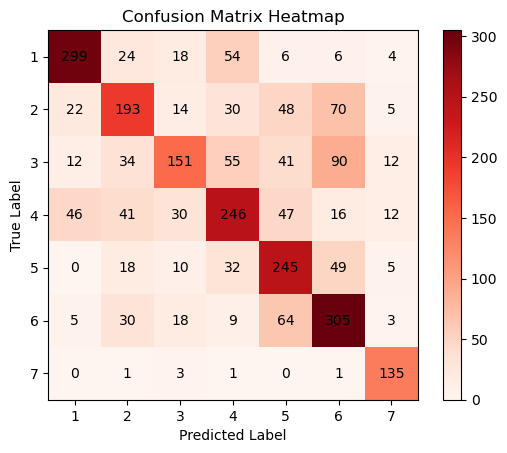

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Your confusion matrix data
confusion_matrix_data = np.array([[299, 24, 18, 54, 6, 6, 4],
                                  [22, 193, 14, 30, 48, 70, 5],
                                  [12, 34, 151, 55, 41, 90, 12],
                                  [46, 41, 30, 246, 47, 16, 12],
                                  [0, 18, 10, 32, 245, 49, 5],
                                  [5, 30, 18, 9, 64, 305, 3],
                                  [0, 1, 3, 1, 0, 1, 135]])

# Plot confusion matrix heatmap using plt.imshow
plt.imshow(confusion_matrix_data, cmap='Reds', interpolation='nearest')

# Add colorbar
plt.colorbar()

# Set ticks for better visualization
plt.xticks(np.arange(len(confusion_matrix_data)), np.arange(1, 8))
plt.yticks(np.arange(len(confusion_matrix_data)), np.arange(1, 8))

# Add labels
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Display the values in each cell
for i in range(len(confusion_matrix_data)):
    for j in range(len(confusion_matrix_data[i])):
        plt.text(j, i, str(confusion_matrix_data[i, j]), ha='center', va='center', color='black')

# Show the plot
plt.show()


In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       Angry       0.78      0.73      0.75       411
   Disgusted       0.57      0.51      0.53       382
     Fearful       0.62      0.38      0.47       395
       Happy       0.58      0.56      0.57       438
     Neutral       0.54      0.68      0.60       359
         Sad       0.57      0.70      0.63       434
   Surprised       0.77      0.96      0.85       141

    accuracy                           0.61      2560
   macro avg       0.63      0.65      0.63      2560
weighted avg       0.62      0.61      0.61      2560



80/80 [==============================] - 1s 8ms/step


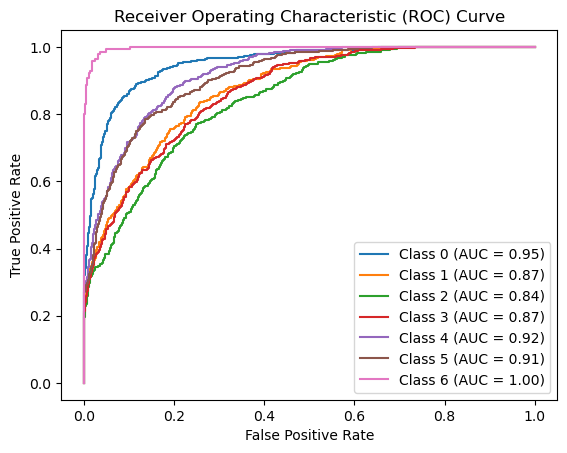

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Convert labels to one-hot encoding for multilabel
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4 , 5, 6 ])  # Replace [...] with your class indices
y_pred_bin = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
for i in range(num_labels):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()


In [24]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test).argmax(axis=1)  # Assuming a multi-class problem; adjust as needed
cm = confusion_matrix(y_test, y_pred)


80/80 [==============================] - 1s 7ms/step


In [25]:
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)



In [26]:
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")


True Positives: [299 193 151 246 245 305 135]
True Negatives: [2064 2030 2072 1941 1995 1894 2378]
False Positives: [ 85 148  93 181 206 232  41]
False Negatives: [112 189 244 192 114 129   6]


In [28]:
model.save("/dataset/my_file.h5")

